## Spectral grid fitting for the SALT spectra

CARMENES spectra:

http://carmenes.cab.inta-csic.es/gto/jsp/reinersetal2018.jsp

In [2]:
from scipy.signal import correlate
from astropy.convolution import Gaussian1DKernel, convolve


In [3]:
import numpy as np
import pandas as pd

import matplotlib 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.constants import R_sun, c
import astropy.units as u

from scipy import interpolate

# Get spectra

In [5]:
dirr = "/home/ekaterina/Documents/001_science/MalachiteMountains/data"
sp1 = pd.read_csv(f"{dirr}/salt/R202002090014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
model = pd.read_csv(f"{dirr}/btsettl/2700K.tsv", delimiter="\s+", skiprows=10, names=["lambd","flux"])
sp2 = pd.read_csv(f"{dirr}/salt/R202002080017.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
sp3 = pd.read_csv(f"{dirr}/salt/R202002080014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
from astropy.io import fits
hdu = fits.open(f"{dirr}/carmenes/carmenes_cnleo_vis.fits")#carmenes_v129s_m8_vis.fits")#carmenes_cnleo_vis.fits")#carmenes_2mucd_m8_vis.fits")
#carmenes_lp731_m65_vis.fits")#carmenes_teegarden_vis.fits")##carmenes_cnleo_vis.fits")

lambd = hdu[4].data.flatten().byteswap().newbyteorder()
flux = hdu[1].data.flatten().byteswap().newbyteorder()
sp4 = pd.DataFrame({"lambd":lambd, "flux":flux}).sort_values(by="lambd", ascending=True)
sp4 = sp4.dropna(how="any")
#sp4.lambd = sp4.lambd - 2.6343301463011812

stri = f"{dirr}/carmenes/carmenes_gj1256_m45_vis.fits"
hdu = fits.open(stri)
lambd = hdu[4].data.flatten().byteswap().newbyteorder()
flux = hdu[1].data.flatten().byteswap().newbyteorder()
carm = pd.DataFrame({"lambd":lambd, "flux":flux}).sort_values(by="lambd", ascending=True)
carm = carm.dropna(how="any")
carm.lambd = carm.lambd #- 2.5 # offset of spectrum
settl7 = pd.read_csv(f"{dirr}/btsettl/2700K.tsv", delimiter="\s+", skiprows=10, names=["lambd","flux"])

# Pick spectral regions

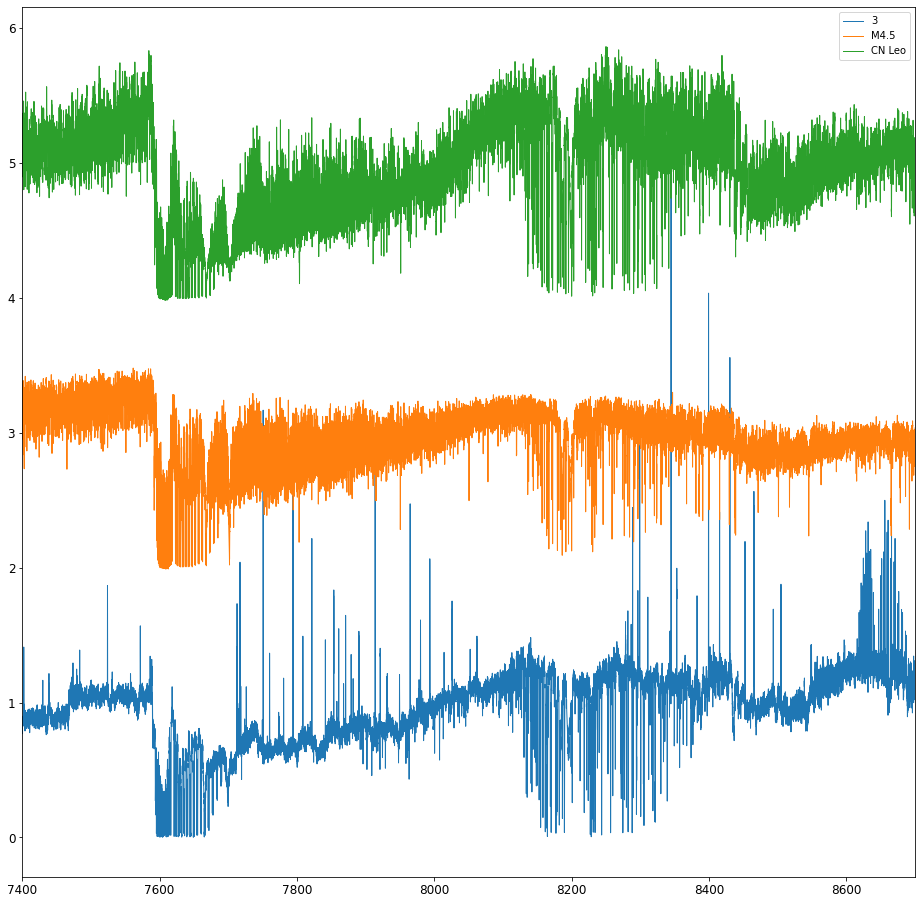

In [22]:
plt.figure(figsize=(16,16))
# for sp in [sp1, sp2, sp3]:
#     plt.errorbar(sp.lambd, sp.flux/, 
#                  yerr=sp.flux_err, c="k", linewidth=1, label="SALT")
    
off = 0
wavmin, wavmax =7400,8700#7938, 7955,#6550, 6580 # 8190,8199#7689,7709#
for sp, lb in [(sp3, "3"),(carm,"M4.5"), (sp4, "CN Leo")]:#(sp1, "1"),(sp2, "2"),
    sp = sp[(sp.lambd<8192.8) | (sp.lambd>8194)]
    sp = sp[(sp.lambd<8197.4) | (sp.lambd>8198.7)]
    wav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    mflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    #mflux = pd.Series(mflux).rolling(40).median().values
    plt.plot(wav,mflux/np.median(mflux)+off , linewidth=1, label=f"{lb}")
    off +=2


# sp44 = sp4[(sp4.lambd>wavmin) & (sp4.lambd<wavmax)]
# plt.plot(sp44.lambd, sp44.flux/np.max(sp44.flux), 
#               c="k", linewidth=1, label="CN Leo")

# sp44 = carm[(carm.lambd>wavmin) & (carm.lambd<wavmax)]
# plt.plot(sp44.lambd, sp44.flux, 
#               c="k", linewidth=1, label="M8norot")

# for col in specs:
#     plt.plot(specs.index, specs[col]/np.max(specs[col]))
plt.axvline(6562.8)
plt.xlim(wavmin, wavmax)
#plt.ylim(-100,1e5)
#plt.ylim(0,4.6)
plt.legend();

In [6]:
mask = pd.read_csv(f"{dirr}/salt/no_tellur_regions.csv")

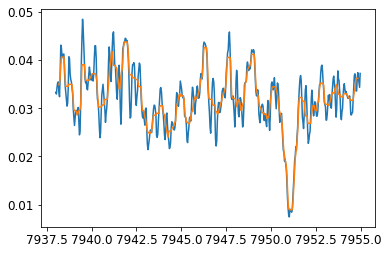

In [9]:

model=sp4


wav = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax),"lambd"].values 

#TEEGARDENS
# model = model[(model.lambd<8192) | (model.lambd>8193)]
# model = model[(model.lambd<8197.02) | (model.lambd>8197.7)]
# model = model[(model.lambd<8198.25) | (model.lambd>8198.9)]

#CN Leo
model = model[(model.lambd<8192) | (model.lambd>8193.2)]
model = model[(model.lambd<8196.5) | (model.lambd>8198)]
model = model[(model.lambd<8198.35) | (model.lambd>8198.9)]



mflux = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax),"flux"].values
wav = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax),"lambd"].values 

# g2 = Gaussian1DKernel(stddev=10.)
# mflux = convolve(mflux, g2)
mflux2 = pd.Series(mflux).rolling(10, center=True).median()
plt.plot(wav,mflux)
plt.plot(wav,mflux2)

In [10]:
sflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
swav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
f = interpolate.interp1d(swav, sflux,fill_value="extrapolate")
sfluxinterp = f(wav)
# sfluxinterp = sfluxinterp / np.max(sfluxinterp)
# wav.shape, sfluxinterp.shape

# Rotational broadening

[see eniric docs](https://eniric.readthedocs.io/en/latest/broadening.html#rotational-broadening)

In [11]:
from eniric import broaden


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/eniric/__init__.py:23: UserWarning: Using the default config.yaml file located at /home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/eniric/config.yaml. This is likely NOT what you want and you will not be able to change any of the config values. Please use config.copy_file(<path>) to copy a version of the default config for your own project.
  UserWarning,


In [12]:
vsinis = np.arange(0,20,1.5)
vsinis

array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ,
       16.5, 18. , 19.5])

In [13]:
specs = pd.DataFrame({"wav":wav})

for vsini in vsinis:
    specs[vsini] = broaden.rotational_convolution(wav, model.lambd, model.flux, vsini)


100%|██████████| 504/504 [00:00<00:00, 731.41it/s]


In [199]:
specs.shape, len(wav)

((509, 25), 509)

In [14]:
# specs.to_csv(f"../../data/eniric/{wavmin}_{wavmax}_gj.csv",index=False)
# specs = pd.read_csv(f"../../data/eniric/{wavmin}_{wavmax}_gj.csv")
specs = specs.set_index("wav")
specs

,0.0,1.5,3.0,4.5,6.0,7.5,9.0,10.5,12.0,13.5,15.0,16.5,18.0,19.5
wav,,,,,,,,,,,,,,
7938.006282,0.033270,0.033058,0.032908,0.032962,0.033315,0.033805,0.034189,0.034573,0.035222,0.035789,0.036214,0.036487,0.036667,0.036792
7938.041068,0.032929,0.033298,0.033583,0.033603,0.033472,0.033492,0.033904,0.034549,0.035204,0.035731,0.036204,0.036569,0.036766,0.036834
7938.075851,0.034387,0.034270,0.034237,0.034069,0.033732,0.033647,0.034058,0.034692,0.035317,0.035786,0.036224,0.036585,0.036794,0.036852
7938.110630,0.035274,0.035126,0.034649,0.034169,0.034078,0.034329,0.034633,0.034993,0.035524,0.035957,0.036291,0.036547,0.036729,0.036801
7938.145405,0.035438,0.034962,0.034435,0.034343,0.034767,0.035197,0.035413,0.035540,0.035851,0.036171,0.036379,0.036505,0.036601,0.036656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7954.838723,0.037354,0.036804,0.036078,0.035523,0.035529,0.035826,0.035895,0.035663,0.035198,0.034691,0.034234,0.033999,0.033913,0.033908
7954.871389,0.036291,0.036310,0.036042,0.035833,0.035846,0.035925,0.035805,0.035466,0.035026,0.034601,0.034307,0.034155,0.034100,0.034116
7954.904050,0.035312,0.035305,0.035781,0.036250,0.036261,0.035897,0.035467,0.035063,0.034736,0.034524,0.034415,0.034357,0.034332,0.034336


In [231]:
# convert wavelength to difference in velocity
l0 = wav[int(len(wav)/2)]
v = ((wav-l0)/wav * c).to("km/s")

In [ ]:
corrf = pd.DataFrame({"v":v})
plt.figure(figsize=(8,8))

for vsini, broad_spectrum in zip(vsinis, specs):
    # Convolve data
    if vsini>0:
        
        corr = correlate(specs[broad_spectrum],mflux, mode="same")
        me = np.max(corr)
        corrf[vsini] = corr/me
        plt.plot(v, corr/me, c="grey", linewidth=0.5,linestyle="dashed")#,label=f"{vsini} km/s")
plt.plot(v, corr/me, c="grey", linewidth=0.5,linestyle="dashed",label=r"CN Leo H$\alpha$ cross-correlation func.")
# corr = correlate(mflux,mflux, mode="same")
# me = np.max(corr)
# plt.plot(v,corr/me, c="grey", linewidth=0.5,label=f"0 km/s")
for sp, num in [(sp1,"1"), (sp2,"2"), (sp3,"3")]:#,sp4]:
    sp = sp[(sp.lambd<7949) | (sp.lambd>7950)]
   # sp = sp.loc[(sp.lambd>8193) & (sp.lambd<8194), "flux"] = np.nan
    sflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    swav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    f = interpolate.interp1d(swav, sflux, fill_value="extrapolate")
    sfluxinterp = f(wav)
    sfluxinterp = sfluxinterp / np.max(sfluxinterp)
    sfluxinterp = sfluxinterp - np.min(sfluxinterp)
    
#     corr = correlate(mflux,sfluxinterp, mode="same")
#     me = np.max(corr)
#     corrf["salt"] = corr/me
#     print(np.max(sfluxinterp),np.max(mflux), np.max(corr))
#     plt.plot(v-45*u.km/u.s,corr/me, label=f"SALT", c="r", linewidth=1)
    
    corr = correlate(sfluxinterp,mflux, mode="same")
    me = np.max(corr)
    corrf["salt" + num] = corr/me
    print(np.max(sfluxinterp),np.max(mflux), np.max(corr))
    plt.plot(v,corr/me, label=f"SALT {num}", linewidth=1)
w = 200
plt.xlim(-w,w)
#plt.ylim(0.65,1.2)
plt.xlabel(r"$v$ [km/s]", fontsize=15)
plt.ylabel("cross-correlation function", fontsize=15)
plt.legend(fontsize=15)
#plt.savefig("../plots/vsini/CNleo_Halpha_cross_corr.png", dpi=300)

In [ ]:
#corrf = corrf[(corrf.v>-1180) & (corrf.v<1180)]
corrf = corrf.set_index("v")

In [ ]:
thresh=0.6
plt.figure(figsize=(12,4))
FWHM = corrf.apply(lambda x:x.index[np.where(x>thresh)[0][-1]]-x.index[np.where(x>thresh)[0][0]], axis=0)
plt.plot(FWHM.index[:-3],FWHM.values[:-3], c="k")
for i in [-3,-2,-1]:
    plt.plot([FWHM.index[0],FWHM.index[-4]],[FWHM.values[i]]*2, label=FWHM.index[i])
plt.xlim(0,150)
plt.legend()

Rough first estimates:  

- 45 km/s, 81 km/s, 103 km/s (thresh 0.7)
- 47 km/s, 115 km/s, 118 km/s (thresh 0.65)

In [ ]:
len(mflux), len(specs["32"])

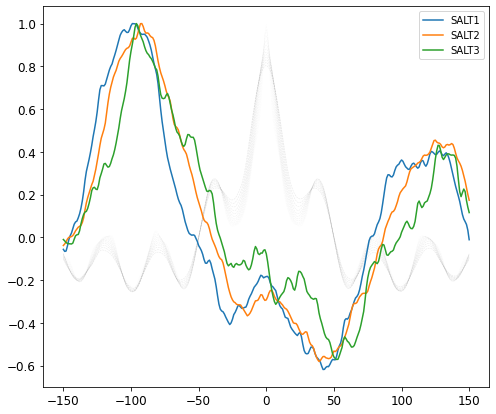

In [16]:
from funcs.xcorr import correlate_maxlag, correlate_template, get_lags
corrf = pd.DataFrame()
plt.figure(figsize=(8,7))
N = len(mflux)
maxlag = 150
start = N // 2
b = mflux
for vsini in specs.columns.values:
    a = specs[vsini]
    cc1 = correlate_maxlag(a, b, maxlag)
    plt.plot(get_lags(cc1), cc1,c="grey", alpha = float(vsini)/100, linewidth=0.5,linestyle="dashed")
    corrf[vsini] = cc1
    
corrsp = {}    

for sp, lab in [(sp1,"1"), (sp2,"2"), (sp3,"3")]:    
    sp = sp[(sp.lambd<8193) | (sp.lambd>8194)]
    sp = sp[(sp.lambd<8197.5) | (sp.lambd>8198.5)]
    sp = sp[(sp.lambd<7949) | (sp.lambd>7950)]
    sflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    
    swav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    f = interpolate.interp1d(swav, sflux, fill_value="extrapolate")
    sfluxinterp = f(wav)
    cc1 = correlate_maxlag(sfluxinterp, b, maxlag)
    plt.plot(get_lags(cc1), cc1/np.max(cc1), label=f"SALT{lab}")
    corrsp[lab] = cc1
plt.legend();

No handles with labels found to put in legend.


9 37
9 37
7 31


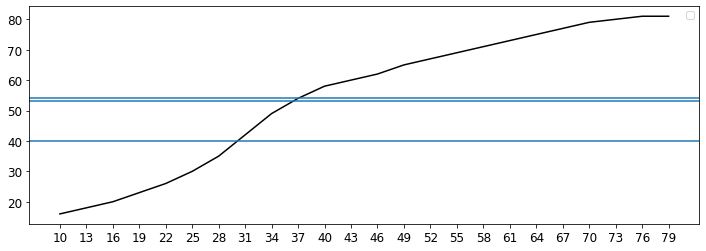

In [233]:
plt.figure(figsize=(12,4))
FWHM = corrf.apply(lambda x:np.where(x>np.max(x)/2.)[0][-1]-np.where(x>np.max(x)/2.)[0][0], axis=0)
plt.plot(FWHM.index, FWHM, c="k")
for i in ["1","2","3"]:
    cc = corrsp[i]
    overhalf = np.where(cc>np.max(cc)/2.)[0]
    fwhm = overhalf[-1] - overhalf[0]
    print(np.argmin((FWHM-fwhm)**2), FWHM.index[np.argmin((FWHM-fwhm)**2)])
    
    plt.axhline(fwhm)
#plt.xlim(0,150)
plt.legend()

Haalpha  vs. CN Leo: 35,25,55
Halpha vs. M8norot: 40, 35, 50


Rb extended (7938, 7955) vs. 2MUCD:41,44,47 (M8)
Rb extended (7938, 7955) vs. CNLeo:35, 38, 38 (M6.5)
Rb extended (7938, 7955) vs. Teegardens:35, 38, 32 (M7)
Rb extended (7938, 7955) vs. LP731:35,41,41 (M6.5)
Rb extended (7938, 7955) vs. V129:40,43,37 (M8)
Rb extended (7938, 7955) vs. GJ1286:(M5.5)

Na at 8195 vs. Teegardens: 80, 83,77
Na at 8195 vs. CN Leo: 86, 89, 74

In [237]:


user_dict = {"GJ1286 (M5.5)":{1:37,2:37,3:31},
    "CN Leo (M6)":{1:35, 2:38, 3:38},
    "LP731 (M6.5)":{1:35,2:41,3:41},
"Teegarden's Star (M7)":{1:35, 2:38,3:32},
"2MUCD (M8)":{1:41,2:44,3:47},
"V129 (M8)":{1:40,2:43,3:37}}

df=pd.DataFrame(user_dict).T
df

,1,2,3
GJ1286 (M5.5),37,37,31
CN Leo (M6),35,38,38
LP731 (M6.5),35,41,41
Teegarden's Star (M7),35,38,32
2MUCD (M8),41,44,47
V129 (M8),40,43,37


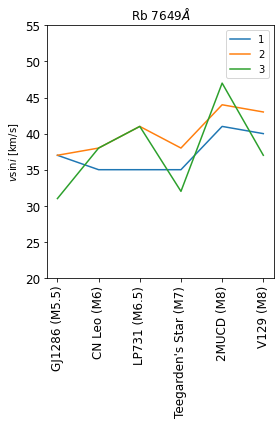

In [238]:
# ms = [r"$m$","*","x","o"]
# for label, row in df.iterrows():
#     print(row.index, row.values)
#     plt.scatter([row.index[0]]*3, row.values, s=200, marker= ms.pop(),label=label,)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(4,6))
df.plot(ax=ax)
plt.legend(loc=(1))
plt.ylim(20,55)
plt.ylabel(r"$v\sin i$ [km/s]")
plt.title(r"Rb $7649\AA$")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../plots/vsini/Rb7649_cross_corr_various_stars.png", dpi=300)